In [73]:
# Python 3 compatability
from __future__ import division, print_function
from builtins import range

# system functions that are always useful to have
import time, sys, os

# basic numeric setup
import numpy as np
import math
from numpy import linalg
from scipy.interpolate import interp1d

# inline plotting
%matplotlib inline

# plotting
import matplotlib
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# seed the random number generator
np.random.seed(7)

from spec_exam import Gen_spec
from sim_engine import forward_model_grism, Salmon
import fsps
from spec_id import Scale_model

import dynesty

In [2]:
# re-defining plotting defaults
from matplotlib import rcParams
rcParams.update({'xtick.major.pad': '7.0'})
rcParams.update({'xtick.major.size': '7.5'})
rcParams.update({'xtick.major.width': '1.5'})
rcParams.update({'xtick.minor.pad': '7.0'})
rcParams.update({'xtick.minor.size': '3.5'})
rcParams.update({'xtick.minor.width': '1.0'})
rcParams.update({'ytick.major.pad': '7.0'})
rcParams.update({'ytick.major.size': '7.5'})
rcParams.update({'ytick.major.width': '1.5'})
rcParams.update({'ytick.minor.pad': '7.0'})
rcParams.update({'ytick.minor.size': '3.5'})
rcParams.update({'ytick.minor.width': '1.0'})
rcParams.update({'font.size': 30})

In [3]:
sp = fsps.StellarPopulation(imf_type = 0, tpagb_norm_type=0, zcontinuous = 1, logzsol = np.log10(0.019/0.019), sfh = 4, tau = 0.1)
wave, flux = sp.get_spectrum(tage = 2.0, peraa = True)

Gs = Gen_spec('GND', 21156, 1.2529, '../beams/o151.0_21156.g102.A.fits', '../beams/o144.0_21156.g141.A.fits',
               g102_lims=[7000, 12000], g141_lims=[10000, 18000],
            phot_errterm = 0.03, decontam = False)  

Gs.Make_sim(0.019, 3.2, 0.2 , 1.2, 0)

/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:544: RuntimeWarning: invalid value encountered in true_divide
  self.optimal_profile = m/m.sum(axis=0)
/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/grizli-0.6.0_115_g3ce5ccf-py3.5-macosx-10.6-x86_64.egg/grizli/model.py:3393: RuntimeWarning: divide by zero encountered in true_divide
  self.ivar = 1/self.grism.data['ERR']**2
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:250: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:252: RuntimeWarning: invalid value encountered in multiply
  sal = 10**(-0.4*k*(lam / lamv)**(delta)*Av/Rv)
/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py:259: RuntimeWarning: divide by zero encountered in log10
  delta = 0.62 * np.log10(Av/Rv) + 0.26
/Users/Vince.ec/

In [88]:
# prior transform
specz = 1.2
def prior_transform(u):
    # return m from 0.001 to 0.03
    # return a from 0.1 to 10
    m = (0.03 * u[0] + 0.001) / 0.019
    a = 5. * u[1] + 0.1
    t = 2*u[2] + 0.01
    z =  specz + 0.01 * (2*u[3] - 1)
    d = 2*u[4]
    return [m, a, t, z, d]

In [81]:
def Full_forward_model(spec, wave, flux, specz):
    Bmwv, Bmflx= forward_model_grism(spec.Bbeam, wave * (1 + specz), flux)
    Rmwv, Rmflx= forward_model_grism(spec.Rbeam, wave * (1 + specz), flux)
    
    Pmfl = spec.Sim_phot_mult(wave * (1 + specz),flux)
    
    Bmfl = Resize(spec.Bwv,Bmwv,Bmflx)
    Rmfl = Resize(spec.Rwv,Rmwv,Rmflx)
    
    return Bmfl, Rmfl, Pmfl

def Full_scale(spec, Bmfl, Rmfl, Pmfl):

    BC = Scale_model(spec.SBflx, spec.SBerr, Bmfl)
    RC = Scale_model(spec.SRflx, spec.SRerr, Rmfl)
    PC = Scale_model(spec.SPflx, spec.SPerr, Pmfl)

    return BC, RC, PC

def Full_fit(spec, Bmfl, Rmfl, Pmfl):

    Bchi = np.sum((((spec.SBflx - Bmfl) / spec.SBerr)**2))
    Rchi = np.sum((((spec.SRflx - Rmfl) / spec.SRerr)**2))
    Pchi = np.sum((((spec.SPflx - Pmfl) / spec.SPerr)**2))
    
    return Bchi, Rchi, Pchi

def Resize(fit_wv, mwv, mfl):
    mfl = np.ma.masked_invalid(mfl)
    mfl.data[mfl.mask] = 0
    mfl = interp1d(mwv,mfl)(fit_wv)
    return mfl

# 3-D correlated multivariate normal log-likelihood

def loglikelihood(X):
    
    m,a,t,z,d = X

    """Multivariate normal log-likelihood."""
    sp.params['logzsol'] = np.log10( m )
    sp.params['tau'] = t
    
    wave, flux = sp.get_spectrum(tage = a, peraa = True)
    
    mwv,mflx= forward_model_grism(Gs.Bbeam, wave * (1 + z), flux)
    
    Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux * Salmon(d, wave), z)
    
    BC, RC, PC = Full_scale(Gs, Bmfl, Rmfl, Pmfl)

    Bchi, Rchi, Pchi = Full_fit(Gs, BC * Bmfl, RC * Rmfl, PC * Pmfl)
                  
    return -0.5 * (Bchi + Rchi + Pchi)

In [95]:
# initialize our nested sampler
ndim = 5
dsampler = dynesty.DynamicNestedSampler(loglikelihood, prior_transform, ndim, nlive=250)

In [96]:
# sample dynamically from the target distribution
dsampler.run_nested(nlive_init=100, nlive_batch=100)

# save results
dres = dsampler.results

iter: 2870 | batch: 6 | bound: 462 | nc: 27 | ncall: 56660 | eff(%):  5.065 | loglstar: -5.888 < -3.805 < -1.746 | logz: -12.398 +/-  0.308 | stop:  3.377            

Exception while calling loglikelihood function:
  params: [1.29060564 3.23711157 0.43235398 1.19817231 0.12413907]
  args: {}
  kwargs: {}
  exception:


Traceback (most recent call last):
  File "/Users/Vince.ec/miniconda3/envs/astroconda/lib/python3.5/site-packages/dynesty/dynesty.py", line 560, in __call__
    return self.func(x, *self.args, **self.kwargs)
  File "<ipython-input-81-0e7ed91a26ef>", line 48, in loglikelihood
    Bmfl, Rmfl, Pmfl = Full_forward_model(Gs, wave, flux * Salmon(d, wave), z)
  File "/Users/Vince.ec/GitHub/Cluster_and_field/scripts/sim_engine.py", line 270, in Salmon
    dust[ii]=dust2[ii]
KeyboardInterrupt


KeyboardInterrupt: 

In [84]:
# posterior case
dsampler.reset()
dsampler.run_nested(nlive_init=100, nlive_batch=100,
                    maxiter=res.niter+res.nlive, use_stop=False, 
                    wt_kwargs={'pfrac': 1.0})
dres_p = dsampler.results

Keys: dict_keys(['samples_it', 'samples_bound', 'bound_iter', 'logvol', 'bound', 'samples_id', 'logz', 'eff', 'ncall', 'logwt', 'samples', 'information', 'niter', 'samples_u', 'scale', 'logl', 'logzerr', 'nlive']) 

Summary
nlive: 250
niter: 3489
ncall: 70130
eff(%):  5.332
logz: -12.571 +/-  0.213


In [85]:
sampler.run_nested(dlogz=0.1)

iter: 3724+250 | bound: 286 | nc: 1 | ncall: 73931 | eff(%):  5.375 | loglstar:   -inf < -0.031 <    inf | logz: -12.571 +/-  0.208 | dlogz:  0.000 >  0.100            

In [86]:
dlogz_final = 0.01

from dynesty.results import print_fn

# continue sampling from where we left off
ncall = sampler.ncall  # internal calls
nit = sampler.it  # internal iteration
for it, results in enumerate(sampler.sample(dlogz=dlogz_final)):
    # split up our results
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzvar,
     h, nc, worst_it, boundidx, bounditer, eff, delta_logz) = results
    # add number of function calls
    ncall += nc
    nit += 1
    # print results
    print_fn(results, nit, ncall, dlogz=dlogz_final)

# add the remaining live points back into our final results 
# (they are removed from our set of dead points each time we start sampling)
for it2, results in enumerate(sampler.add_live_points()):
    # split up results
    (worst, ustar, vstar, loglstar, logvol, logwt, logz, logzvar,
     h, nc, worst_it, boundidx, bounditer, eff, delta_logz) = results
    # print results
    print_fn(results, nit, ncall, add_live_it=it2+1, dlogz=dlogz_final)

res2 = sampler.results

iter: 4303+250 | bound: 345 | nc: 1 | ncall: 87221 | eff(%):  5.219 | loglstar:   -inf < -0.007 <    inf | logz: -12.571 +/-  0.204 | dlogz:  0.000 >  0.010            

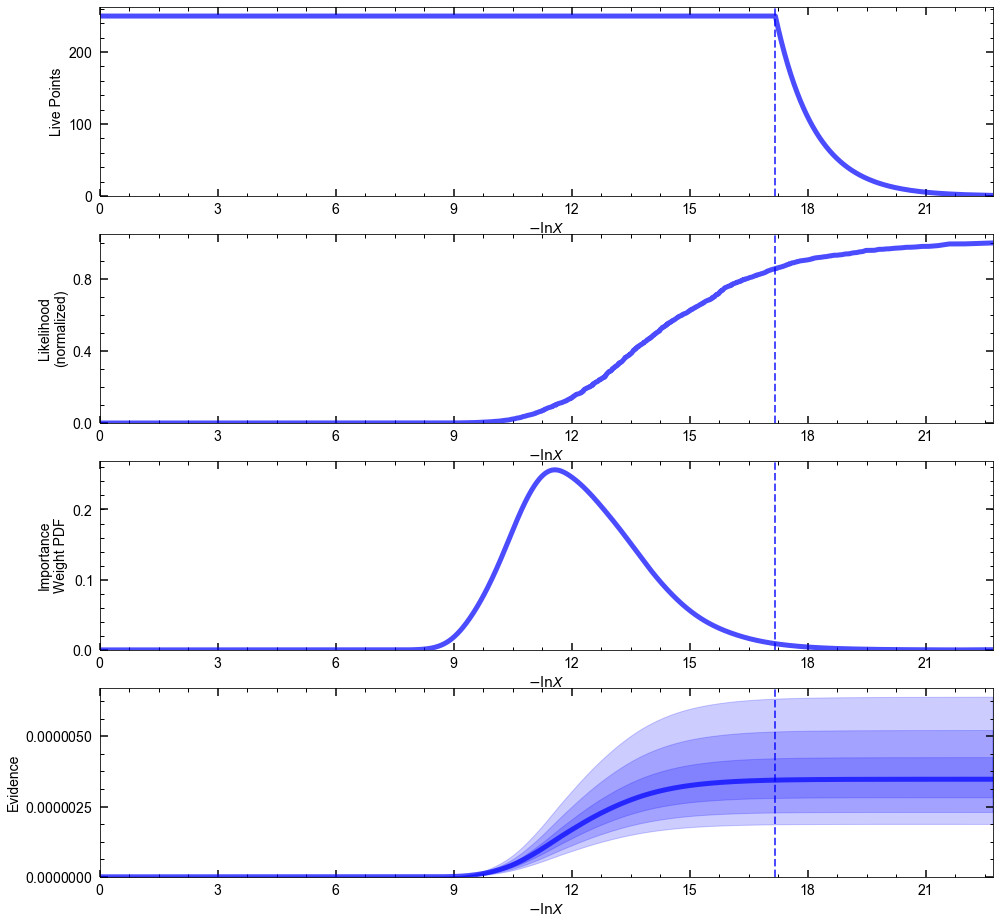

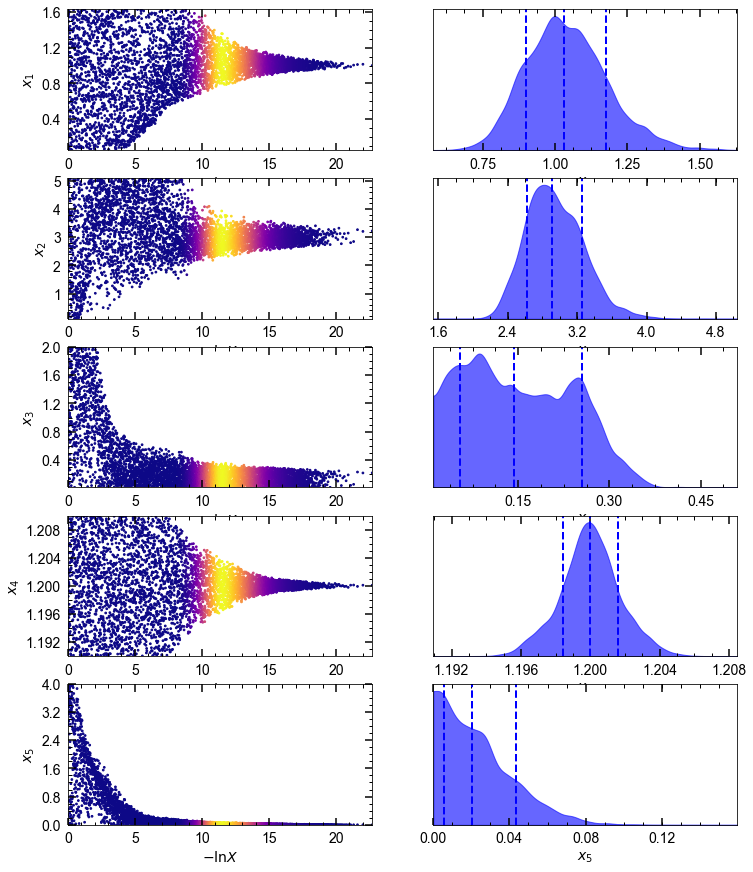

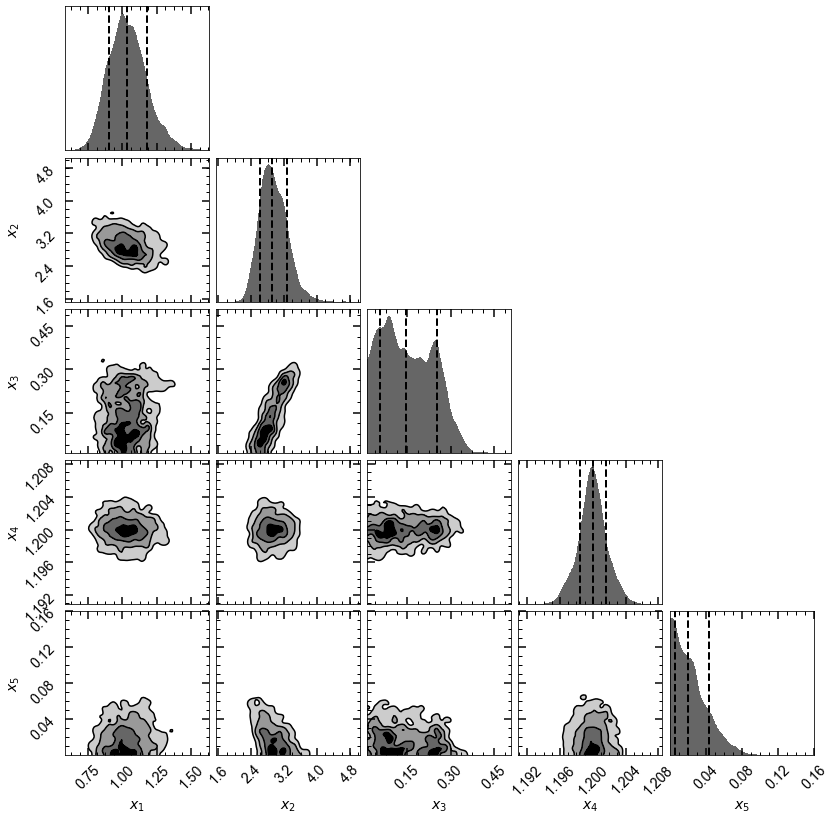

In [97]:
# Plot a summary of the run.
rfig, raxes = dyplot.runplot(res2)
# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(res2)
# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(res2)

In [40]:
from dynesty import plotting as dyplot

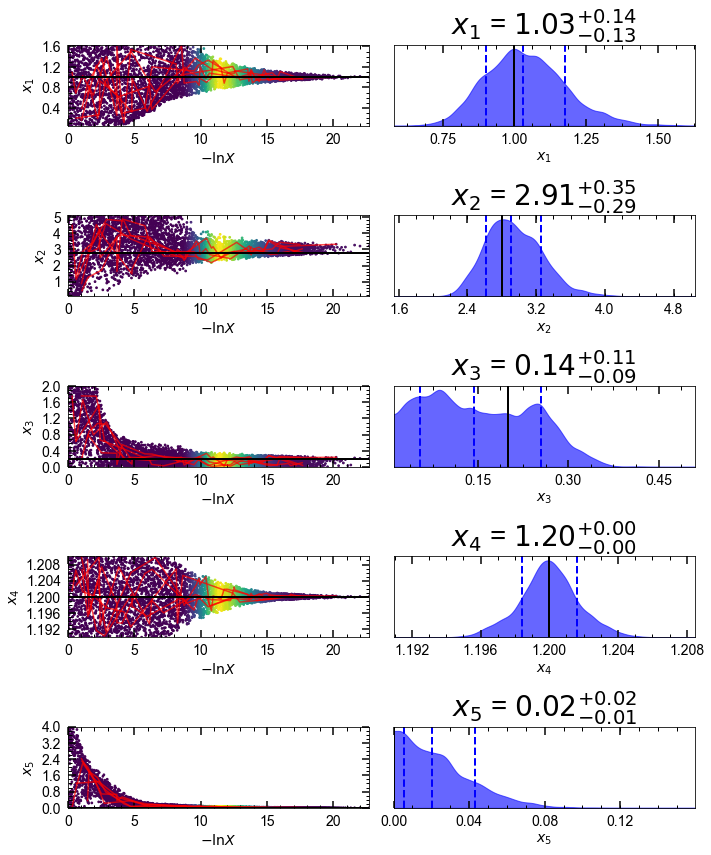

In [109]:
# plotting the continued run
fig, axes = dyplot.traceplot(res2, truths=[1., 2.8, 0.2, 1.2, 0.], truth_color='black',
                             show_titles=True, title_kwargs={'fontsize': 28, 'y': 1.05},
                             trace_cmap='viridis', kde=False,
                             connect=True, connect_highlight=range(5),
                             fig=plt.subplots(5, 2, figsize=(10, 12)))
fig.tight_layout()

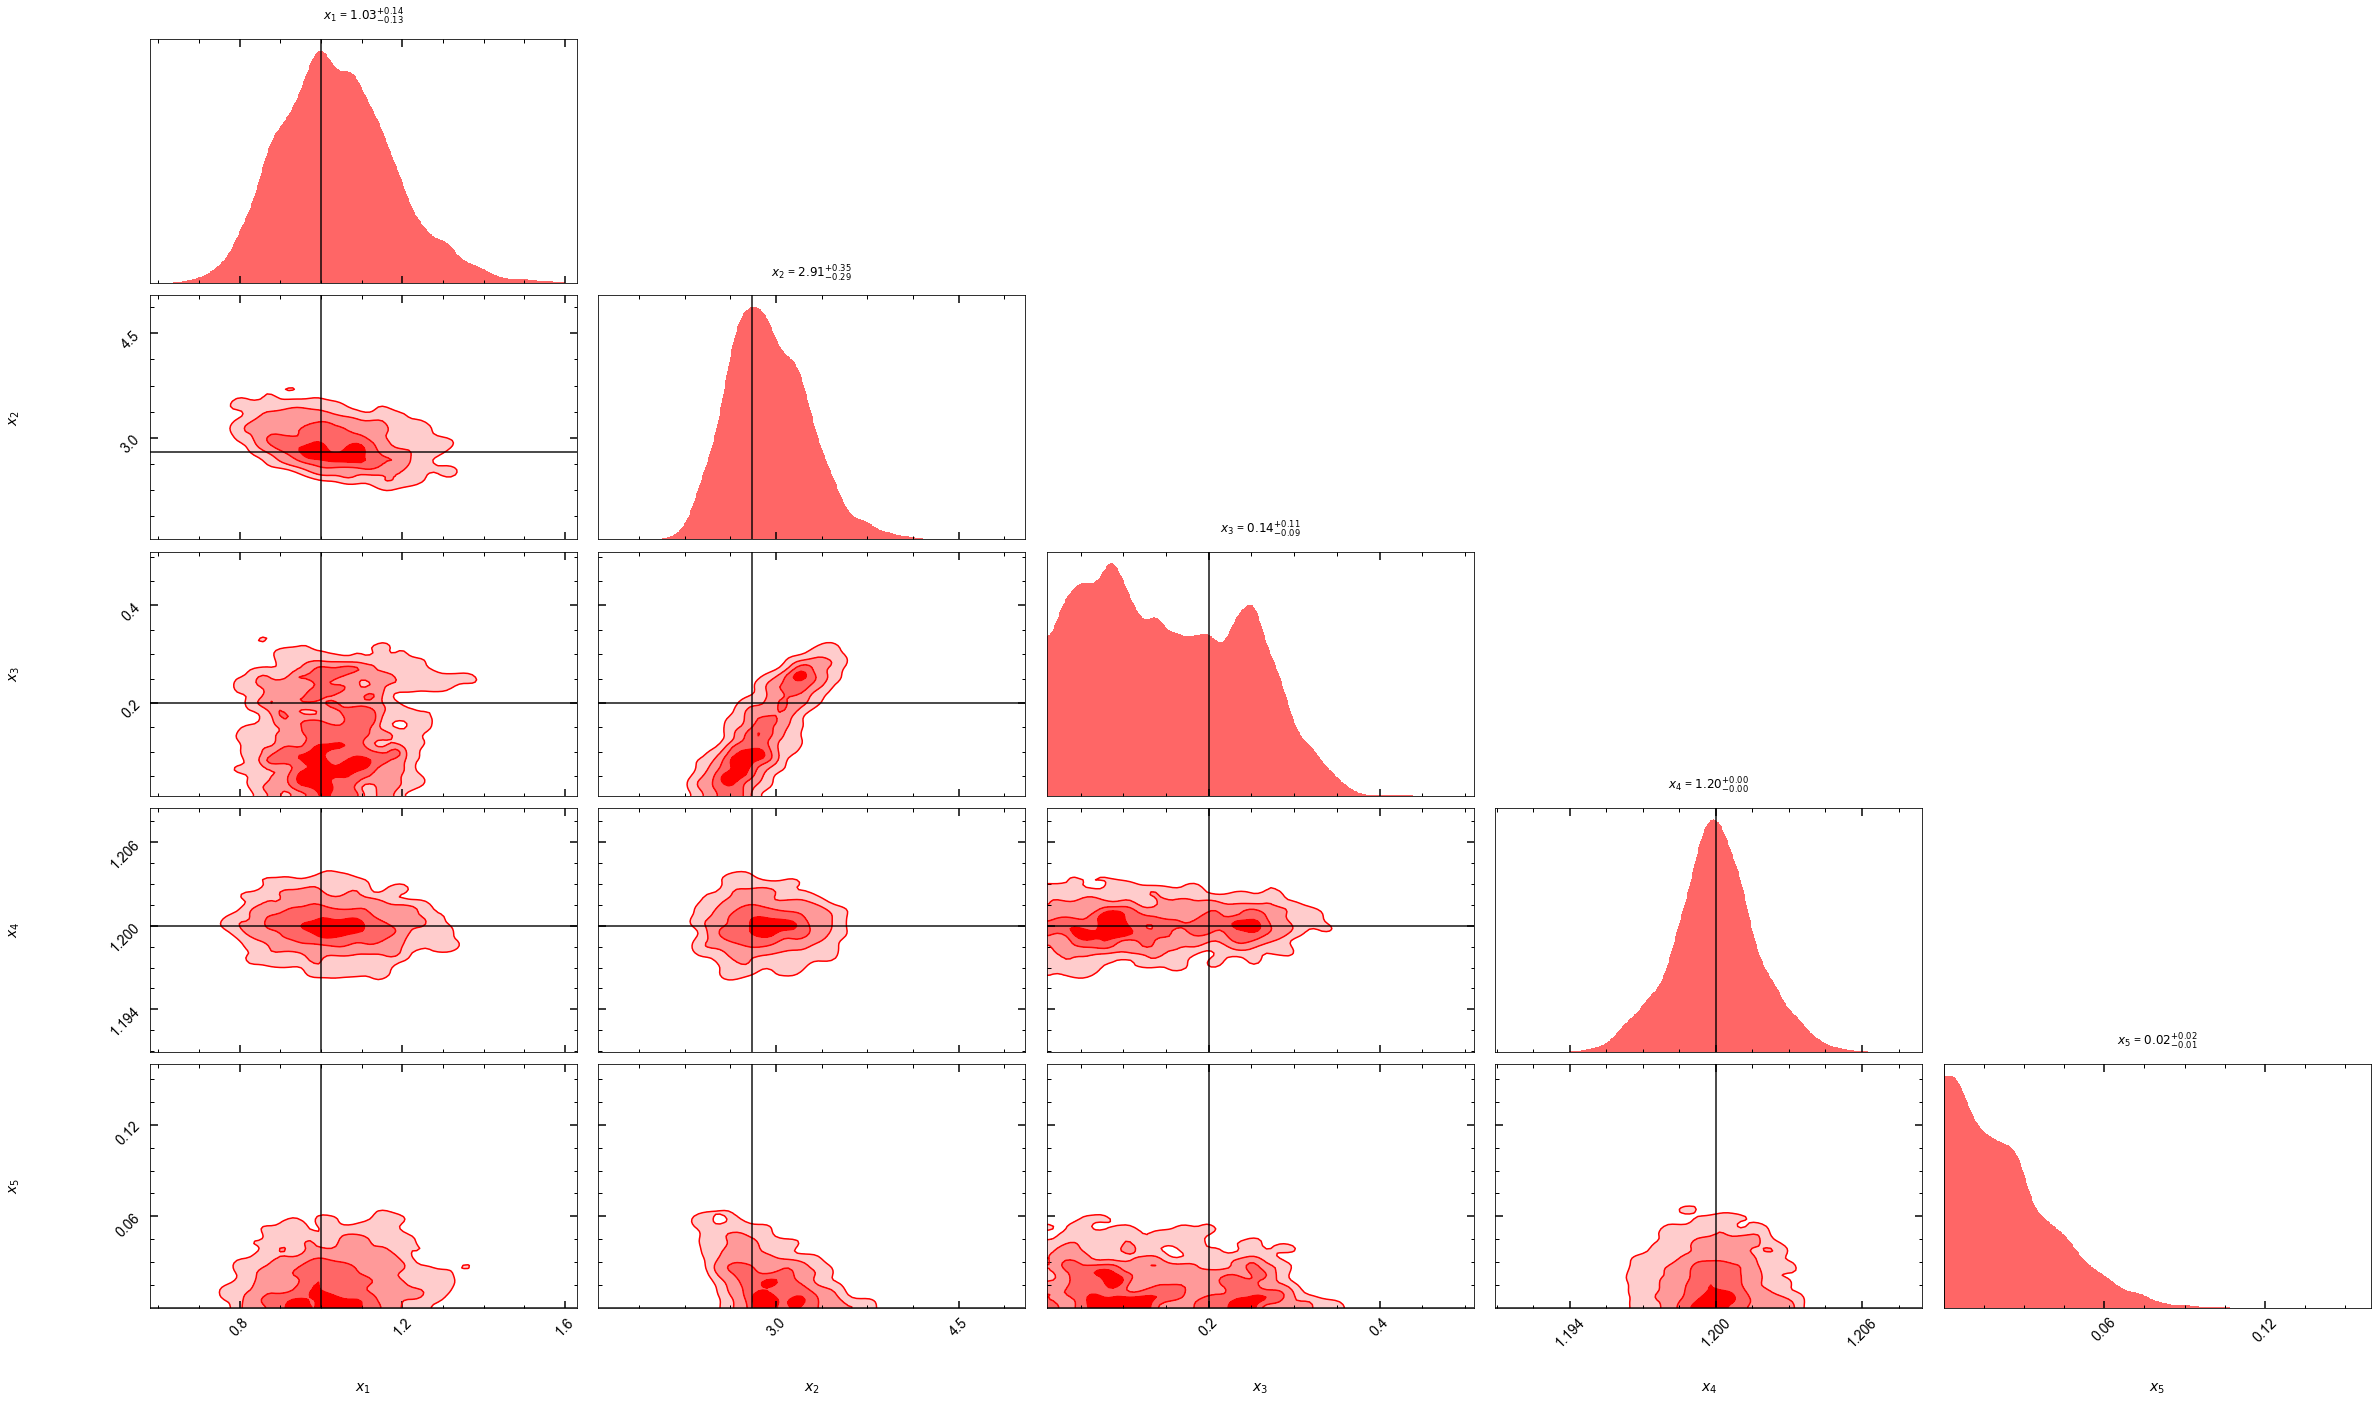

In [108]:
# initialize figure
fig, axes = plt.subplots(5, 5, figsize=(35, 20))
axes = axes.reshape((5, 5))

# plot extended run (right)
fg, ax = dyplot.cornerplot(res2, color='red', truths=[1., 2.8, 0.2, 1.2, 0.], truth_color='black',
                           show_titles=True, title_kwargs={'y': 1.05},
                           quantiles=None, max_n_ticks=3, fig=(fig, axes))